# Importer les bibliotheques 

In [3]:
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras import layers, losses, optimizers, applications
import matplotlib.pyplot as plt
import numpy as np
import os

# Charger les données

In [4]:
train_df = image_dataset_from_directory(
    directory='D:\\VS_python\\Projet\\train',
    image_size=(224, 224),
    batch_size=40,
    shuffle=True,
    seed=42
)

test_df = tf.keras.preprocessing.image_dataset_from_directory(
    directory='D:\\VS_python\\Projet\\test',
    image_size=(224, 224),
    batch_size=40,
    shuffle=True,
    seed=42
)

val_df = tf.keras.preprocessing.image_dataset_from_directory(
    directory='D:\\VS_python\\Projet\\validation',
    image_size=(224, 224),
    batch_size=40,
    shuffle=True,
    seed=42
)

class_names = train_df.class_names
n_class = len(class_names)


Found 15611 files belonging to 47 classes.
Found 3374 files belonging to 47 classes.
Found 3352 files belonging to 47 classes.


## Afficher un échantillon 

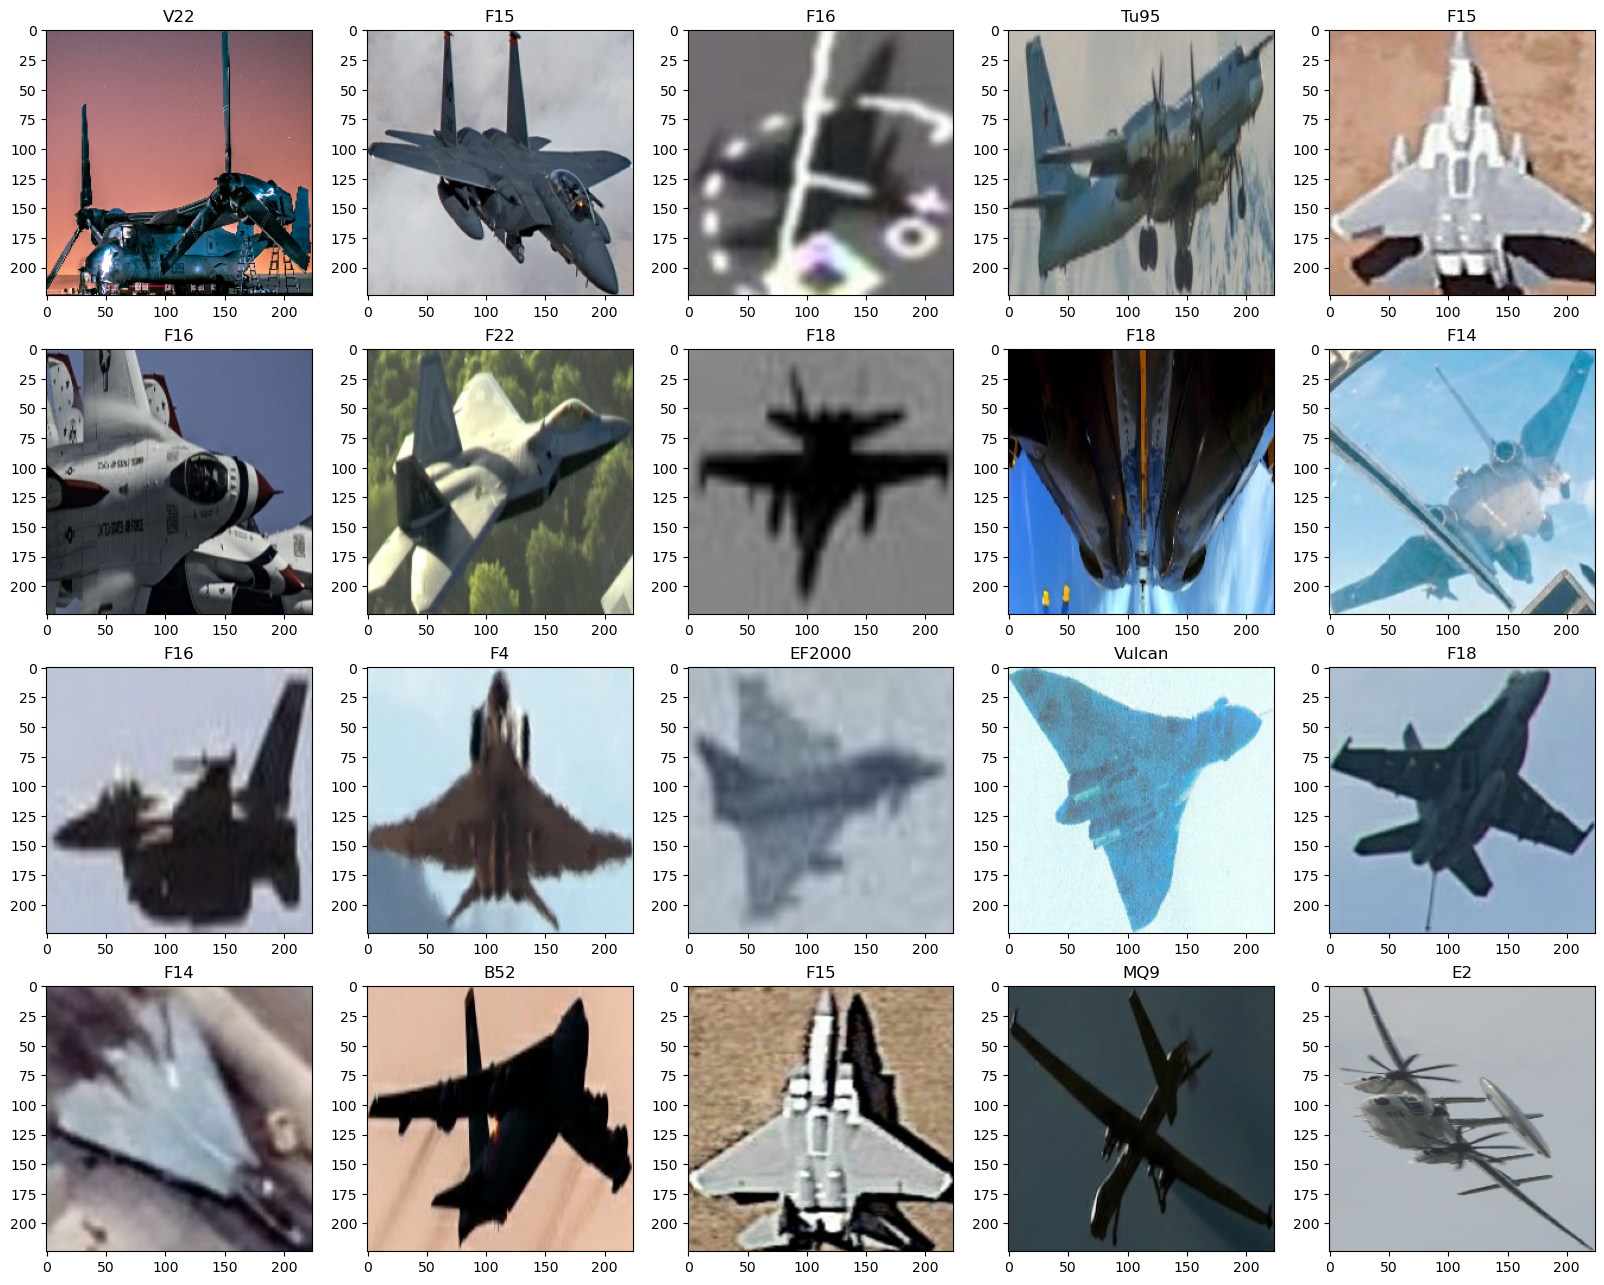

In [5]:

plt.figure(figsize = (20, 20))
for images, labels in train_df.take(1):
    for i in range(20):
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])

## Visualiser la répartition des classes

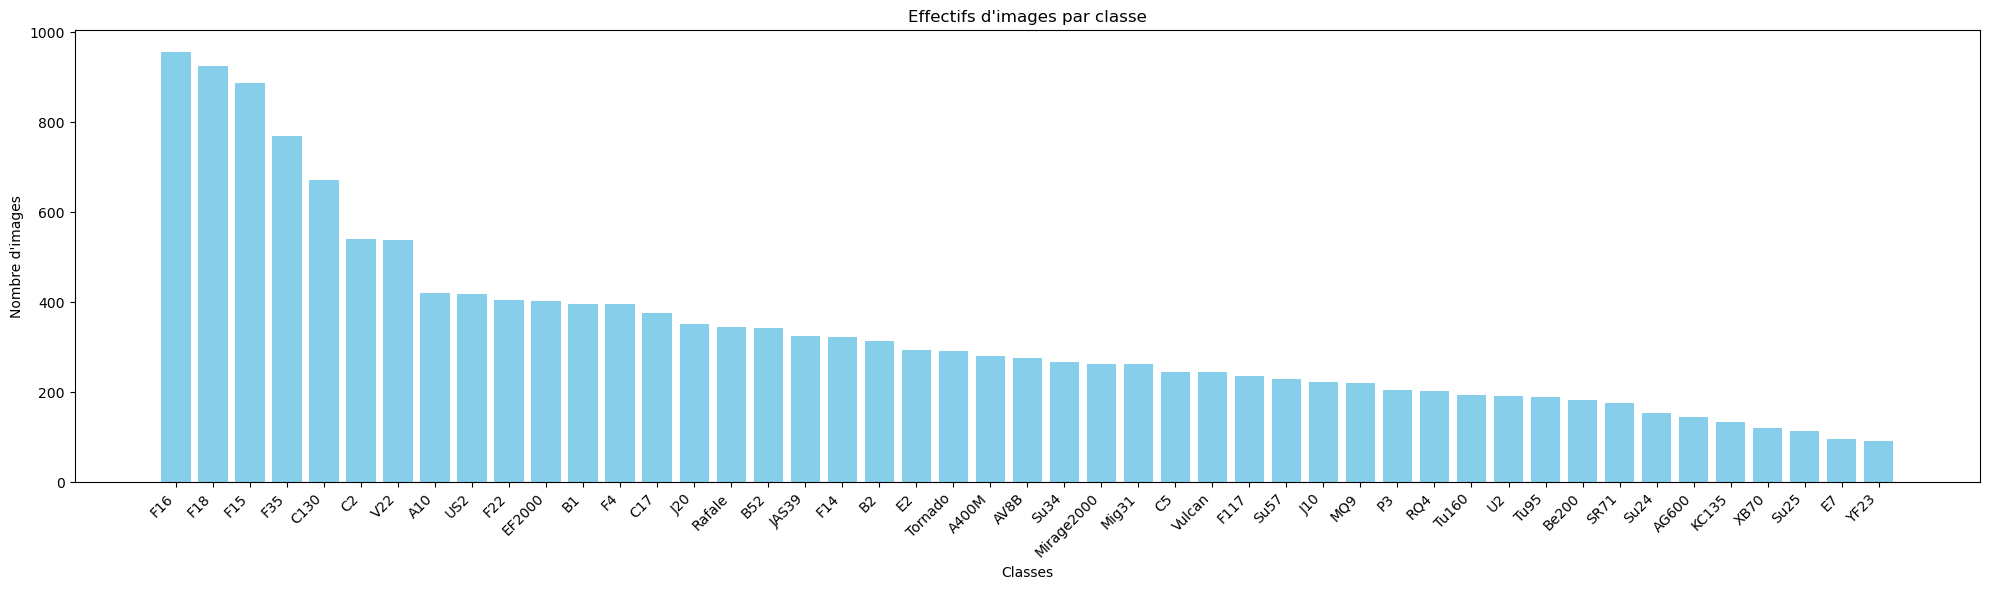

In [6]:
train_dir = 'D:\\VS_python\\Projet\\train'
classes = []
effectifs = []

for classe in os.listdir(train_dir):
    classes.append(classe)
    nb_images = len(os.listdir(os.path.join(train_dir, classe)))
    effectifs.append(nb_images)

classes, effectifs = zip(*sorted(zip(classes, effectifs), key=lambda x: x[1], reverse=True))

plt.figure(figsize=(20, 6))
plt.bar(classes, effectifs, color='skyblue')
plt.xlabel('Classes')
plt.ylabel('Nombre d\'images')
plt.title('Effectifs d\'images par classe')
plt.xticks(rotation=45, ha='right')  
plt.tight_layout()  
plt.show()


### Prefetching data pour accélérer l'entrainement

In [8]:
autotune = tf.data.AUTOTUNE
train_df = train_df.prefetch(buffer_size = autotune)
test_df = test_df.prefetch(buffer_size = autotune)
val_df = val_df.prefetch(buffer_size = autotune)

## Data augmentation 

In [9]:
data_augmentation = tf.keras.Sequential([
    layers.RandomRotation(0.3),
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomZoom(0.2)
    
])

In [10]:
train_df = train_df.map(lambda x, y: (data_augmentation(x), y))
val_df = val_df.map(lambda x, y: (data_augmentation(x), y))

## Implémentation du modèle

In [11]:
Res_model = applications.ResNet50(input_shape = (224,224,3), include_top = False, weights = 'imagenet')
Res_model.trainable = False
Res_model.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,587,712 (89.98 MB)

In [18]:
global_avg = layers.GlobalAveragePooling2D()
preprocess_input = applications.resnet50.preprocess_input
output_layer = layers.Dense(n_class, activation = 'softmax')

In [20]:
inputs = tf.keras.Input(shape = (224, 224,3))
x = data_augmentation(inputs)
x = preprocess_input(inputs)
x = Res_model(x)
x = global_avg(x)
outputs = output_layer(x)
model = tf.keras.Model(inputs = inputs, outputs = outputs)

### Optimisation et Compilation du modèle

In [21]:
optimizer = optimizers.Adam(learning_rate = optimizers.schedules.CosineDecay(0.001, 500))
loss = losses.SparseCategoricalCrossentropy()
model.compile(optimizer = optimizer, loss = loss, metrics = ['accuracy'])

##### 1 ère entrainement

In [22]:
history = model.fit(train_df, validation_data = (val_df), epochs = 1)

391/391 ━━━━━━━━━━━━━━━━━━━━ 1736s 4s/step - accuracy: 0.2444 - loss: 3.0684 - val_accuracy: 0.5508 - val_loss: 1.7226


In [23]:
Res_model.trainable = True
for layer in Res_model.layers[:100]:
    layer.trainable = False

In [24]:
optimizer = optimizers.RMSprop(learning_rate = optimizers.schedules.CosineDecay(0.001, 500))
model.compile(optimizer = optimizer, loss = loss, metrics = ['accuracy'])
history_fine = model.fit(train_df, validation_data = (val_df), epochs = 4)

Epoch 1/4
391/391 ━━━━━━━━━━━━━━━━━━━━ 3290s 8s/step - accuracy: 0.4379 - loss: 2.2337 - val_accuracy: 0.9138 - val_loss: 0.3477
Epoch 2/4
391/391 ━━━━━━━━━━━━━━━━━━━━ 3005s 8s/step - accuracy: 0.9164 - loss: 0.3324 - val_accuracy: 0.9283 - val_loss: 0.2922
Epoch 3/4
391/391 ━━━━━━━━━━━━━━━━━━━━ 3006s 8s/step - accuracy: 0.9538 - loss: 0.2280 - val_accuracy: 0.9277 - val_loss: 0.2935
Epoch 4/4
391/391 ━━━━━━━━━━━━━━━━━━━━ 2976s 8s/step - accuracy: 0.9534 - loss: 0.2284 - val_accuracy: 0.9283 - val_loss: 0.2922


### Evaluation du modèle

In [28]:
test_loss, test_accuracy = model.evaluate(test_df)
print("Test Accuracy:", test_accuracy)

85/85 ━━━━━━━━━━━━━━━━━━━━ 293s 3s/step - accuracy: 0.8460 - loss: 0.5309
Test Accuracy: 0.847065806388855


### Sauvegarder le modèle

In [27]:
tf.saved_model.save(model, 'D:\\VS_python\\Code\\ResNet_officiel_Dataset1')

INFO:tensorflow:Assets written to: D:\VS_python\Code\ResNet_officiel_Dataset1\assets


INFO:tensorflow:Assets written to: D:\VS_python\Code\ResNet_officiel_Dataset1\assets


In [29]:
predictions = model.predict(test_df)
predicted_labels = np.argmax(predictions, axis=1)

85/85 ━━━━━━━━━━━━━━━━━━━━ 325s 4s/step


In [32]:
test_probabilities = []
true_labels = []

for image_batch, label_batch in test_df:
    predictions = model.predict(image_batch)
    test_probabilities.extend(predictions)
    true_labels.extend(label_batch.numpy())  

test_probabilities = np.array(test_probabilities)
true_labels = np.array(true_labels)

print(f"Taille des vraies étiquettes: {true_labels.shape}")
print(f"Taille des probabilités prédites: {test_probabilities.shape}")


2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 3s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 614ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 625ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 609ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 619ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 641ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 609ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 609ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 609ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 609ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 625ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 607ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 625ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 609ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 625ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 609ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 641ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 609ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 634ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 615ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 641ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 609ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 625ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 625ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 641ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 

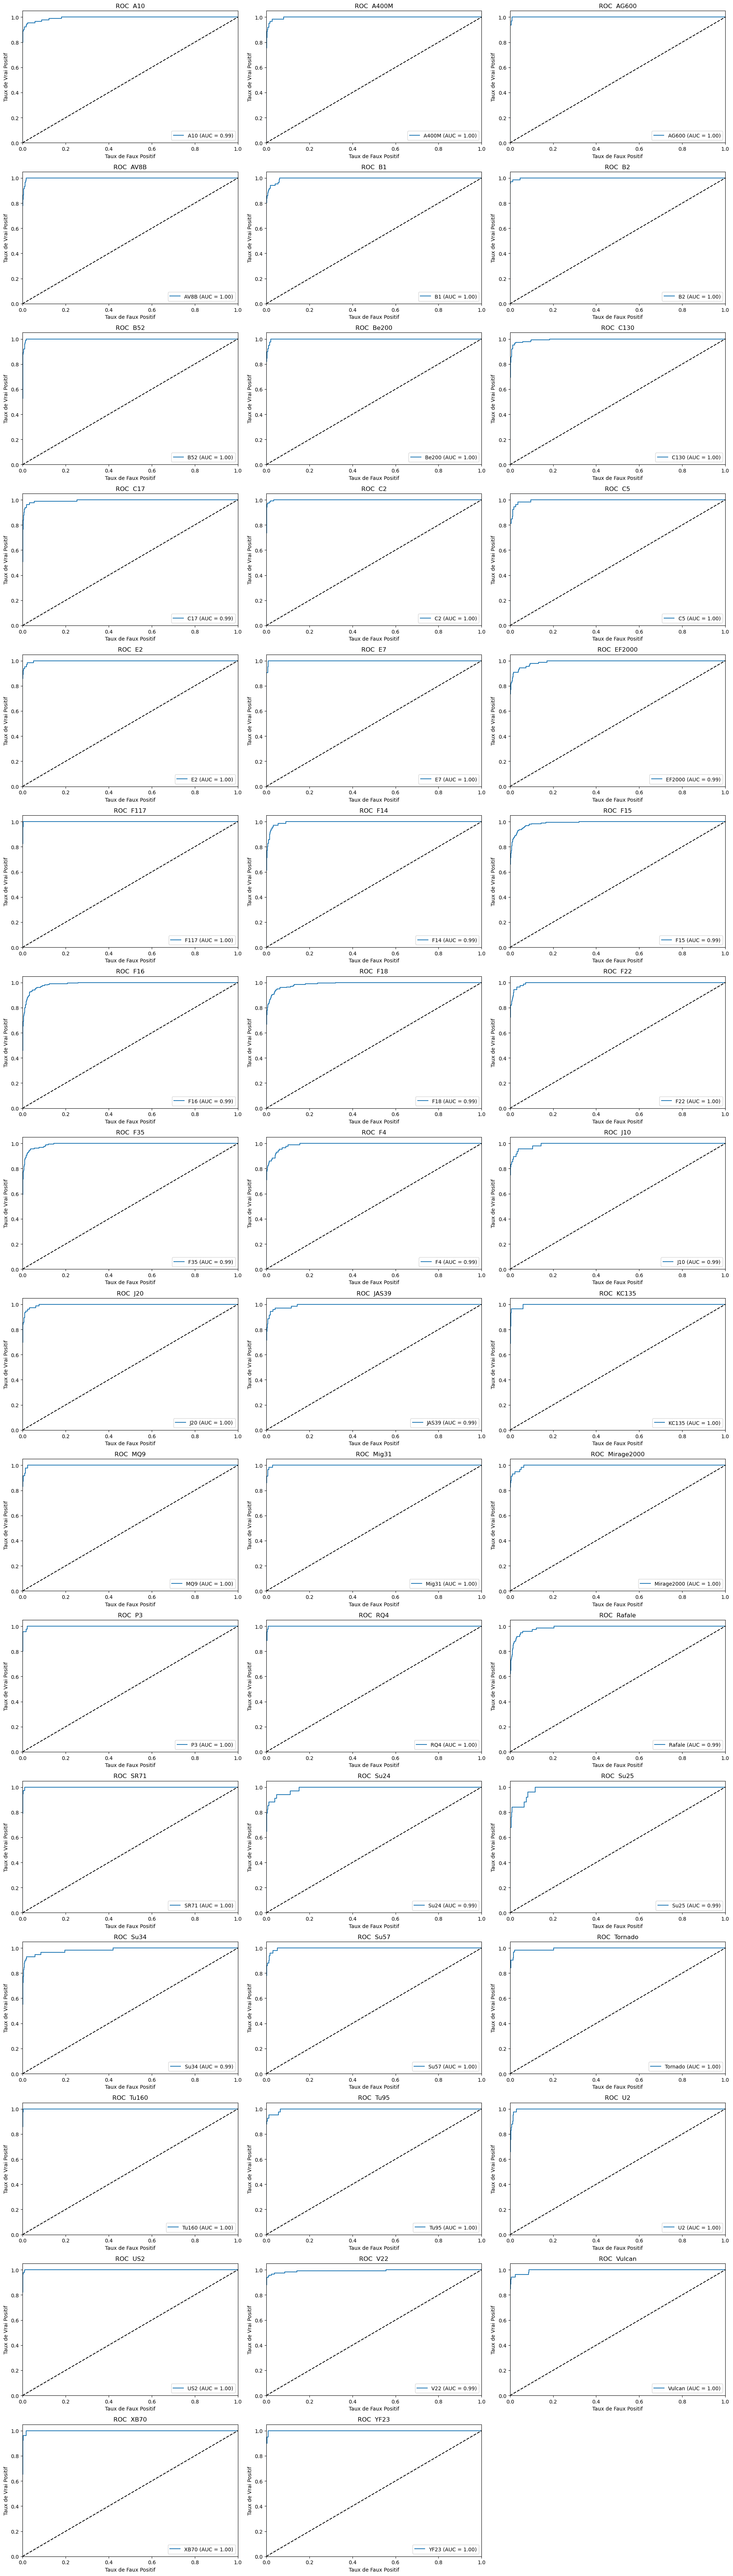

In [33]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import os

train_dir = 'D:\\VS_python\\Projet\\train'
class_names = sorted(os.listdir(train_dir))

n_classes = len(class_names) 
y_true_binarized = label_binarize(true_labels, classes=range(n_classes))

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_binarized[:, i], test_probabilities[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fig, axes = plt.subplots(nrows=(n_classes // 3+ 1), ncols=3, figsize=(20, 70))
for i, ax in enumerate(axes.flat):
    if i < n_classes:
        ax.plot(fpr[i], tpr[i], label=f'{class_names[i]} (AUC = {roc_auc[i]:.2f})')
        ax.plot([0, 1], [0, 1], 'k--')
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('Taux de Faux Positif')
        ax.set_ylabel('Taux de Vrai Positif')
        ax.set_title(f'ROC  {class_names[i]}')
        ax.legend(loc="lower right")
    else:
        ax.axis('off')

plt.tight_layout()
plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 728ms/step


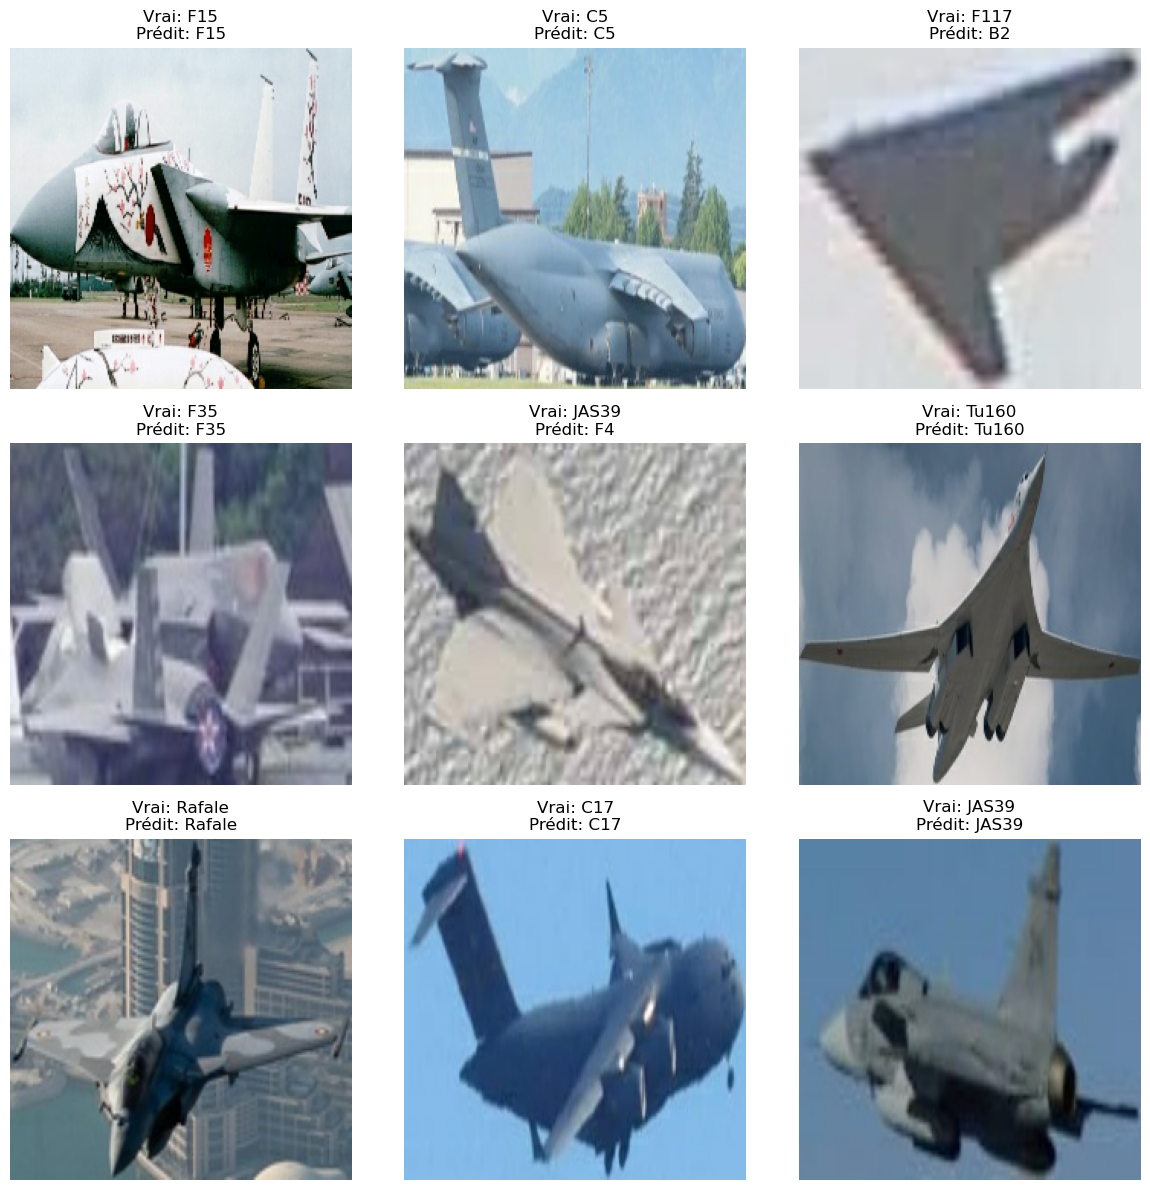

In [39]:
import matplotlib.pyplot as plt
import numpy as np

image_batch, label_batch = test_df.as_numpy_iterator().next()
pred_labels = np.argmax(model.predict(image_batch), axis=1)
label_batch_class = [class_names[i] for i in label_batch]
pred_labels_class = [class_names[i] for i in pred_labels]

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12, 12))  
axes = axes.flatten()

for i, ax in enumerate(axes):
    if i < len(image_batch):  
        ax.imshow(image_batch[i].astype("uint8"))
        ax.set_title(f"Vrai: {label_batch_class[i]}\nPrédit: {pred_labels_class[i]}")
        ax.axis('off')
    else:
        ax.axis('off')  

plt.tight_layout()
plt.show()


### Predire une image Telechargée

In [35]:
from tensorflow.keras.preprocessing import image

def predict_image(model, class_names, image_path):
    img = image.load_img(image_path, target_size=(224, 224))  
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = applications.resnet50.preprocess_input(img_array)
    
    predictions = model.predict(img_array)
    
    predicted_class = class_names[np.argmax(predictions)]
    
    plt.imshow(img)
    plt.title(f"Prédiction: {predicted_class}")
    plt.axis('off')
    plt.show()

In [12]:
image_path_to_predict = 'D:\\VS_python\\F-15EX.webp'  
predict_image(model, class_names, image_path_to_predict)

NameError: name 'predict_image' is not defined